In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles
T = 3.0

from src.energies.lennardjones_energy import LennardJonesEnergy, lennard_jones_energy_torch
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=T
    )

In [5]:
def rademacher(shape, dtype=torch.float32, device='cuda'):
    """Sample from Rademacher distribution."""
    rand = ((torch.rand(shape) < 0.5)) * 2 - 1
    return rand.to(dtype).to(device)

def compute_laplacian_exact(model, t, xt):
    def func_wrap(t, xt):
        return model(t.unsqueeze(0), xt.unsqueeze(0)).squeeze()
    
    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(torch.func.jacrev(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()

def compute_laplacian_hutchinson(nabla_Ut, t, xt):
    # Compute the noise
    noise = rademacher(xt.shape, dtype=torch.float32, device=xt.device)
    # Compute the jvp of the nabla_Ut and the noise
    jvp = torch.autograd.grad(nabla_Ut, xt, noise, create_graph=True)[0] # nabla(nabla_Ut) * noise
    laplacian = (jvp * noise).sum(-1)
    return laplacian.detach()


def compute_laplacian(model, nabla_Ut, t, xt, n_samples, exact=True):
    if exact:
        return compute_laplacian_exact(model, t, xt)
    else:
        laplacian = 0
        for _ in range(n_samples):
            laplacian += compute_laplacian_hutchinson(nabla_Ut, t, xt)
        return laplacian / n_samples

## Function Definitions

In [6]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu())
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    return ids, next_u


def sample_cat_sys(bs, next_u, logits):
    u = torch.rand(size=(1,), dtype=torch.float64)
    u = (u + 1/bs*torch.arange(bs)) % 1.0
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu())
    return ids, None

In [26]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, noise_schedule):
        super().__init__()
        self.model = model
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None, T=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)
            epsilon_t = self.g(t, x).pow(2) / 2 

            nabla_Ut = self.model(t, x)
            drift_X = nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None:# or t[0]>0.7:
                return  drift_X, drift_A
            
            # laplacian_b = compute_laplacian(self.model, nabla_Ut, t, x, 1, exact=True)
            # drift_A = epsilon_t * (-laplacian_b *  (T-1) - nabla_Ut.pow(2).sum(-1) * (T-1) * T)
            drift_A = epsilon_t * (-nabla_Ut.pow(2).sum(-1) * (T-1) * T)
        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

def euler_maruyama_step_coupled(sde, x, t, a, dt, step, resampling_interval, T, u_next):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, T)
    drift_Xt = drift_Xt * dt * T
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device) / sqrt(T)

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next, u_next

    #resample based on the weights
    #choice, _ = sample_cat(x.shape[0], u_next, a_next)
    choice, u_next = sample_cat_sys(x.shape[0], u_next, a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, u_next


def integrate_sde_coupled(sde, x0, t_span, dt, resampling_interval, T):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    u_next = 0.5
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, u_next = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, resampling_interval, T, u_next)
            x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, resampling_interval=None, T=1.0):
    integrator = integrate_sde_coupled
    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrator(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval = resampling_interval,
        T=T
    )
    return samples[-1], weights

In [8]:
# sample from a tensor
def sample_from_tensor(tensor, num_samples):
    idx = torch.randint(0, tensor.shape[0], (num_samples,))
    return tensor[idx]


# calculate the log expectation of the reward
def log_E_R(_x, _t, energy, noise_schedule, num_mc_samples):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t) 
    h_t = h_t.unsqueeze(1)

    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    # log_rewards = target(target.unnormalize(samples))
    log_rewards = energy(samples)
    log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R


def estimate_grad_Rt(xt,
                     t,
                     energy,
                     noise_schedule,
                     num_mc_samples=100):
    est_scores_n = torch.func.grad(log_E_R)(xt, t, energy, noise_schedule, num_mc_samples)
    return est_scores_n

In [9]:
def reward_matching_loss(estimator,
                         model,
                         energy,
                         x,
                         t,
                         noise_schedule,
                         num_mc_samples=100,
                         clip=True
    ):


    x.requires_grad = True

    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)

    # predicted score
    pred_scores = model(t, xt)

    estimated_scores = torch.vmap(estimator, randomness="different",
                                  in_dims=(0, 0, None, None))(
                                    xt,
                                    t,
                                    energy,
                                    noise_schedule,
                                    num_mc_samples=num_mc_samples,
    ).detach()


    if clip:
        estimated_scores = estimated_scores.view(-1, target.n_particles, target.n_spatial_dim)
        estimated_scores = clipper.clip_scores(estimated_scores)
        estimated_scores = estimated_scores.view(-1, target.n_particles * target.n_spatial_dim)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

### Training

In [28]:
from src.models.components.noise_schedules import GeometricNoiseSchedule
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=3)
noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=5)

prior samples torch.Size([1024, 39])


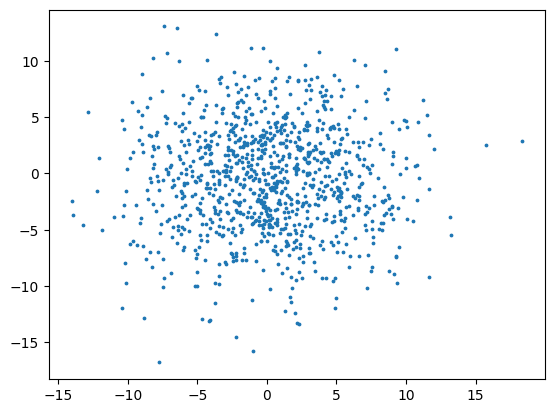

In [29]:
prior = MeanFreePrior(n_particles, spatial_dim, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(1024).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

print("prior samples", x1_samples.shape)

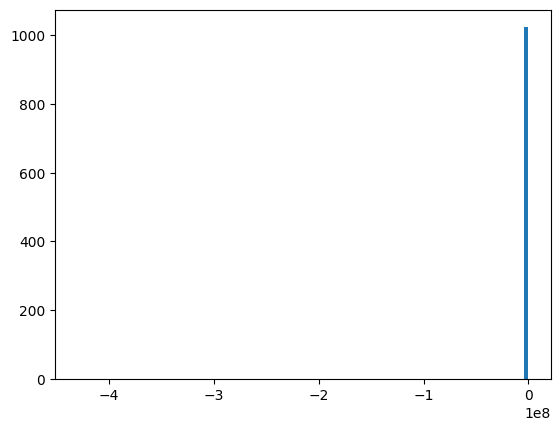

In [30]:
x1_enegry = target(x1_samples, T=1.0)
plt.hist(x1_enegry.detach().cpu().numpy(), bins=100);

In [31]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [32]:
# clipper = Clipper(
#     should_clip_scores=True, should_clip_log_rewards=False, max_score_norm=100
# )

clipper = Clipper(
    should_clip_scores=True, should_clip_log_rewards=False, max_score_norm=200
)

In [33]:
outer_epochs= 10
inner_epochs = 100

batch_size = 512

x1_samples_energy = target(x1_samples.detach())
buffer.add(x1_samples, x1_samples_energy)

train_dataset = TensorDataset(x1_samples.detach(), x1_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 1000

In [34]:
from src.models.components.egnn import EGNN_dynamics
model = EGNN_dynamics(n_particles=target.n_particles,
                      n_dimension=target.n_spatial_dim,
                      hidden_nf=32,
                      act_fn=torch.nn.SiLU(),
                      n_layers=3,
                      recurrent=True,
                      tanh=True,
                      attention=True,
                      condition_time=True,
                      agg='sum').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Loss 1.625031
Epoch 49 | Loss 13.528943
Epoch 98 | Loss 4.802444


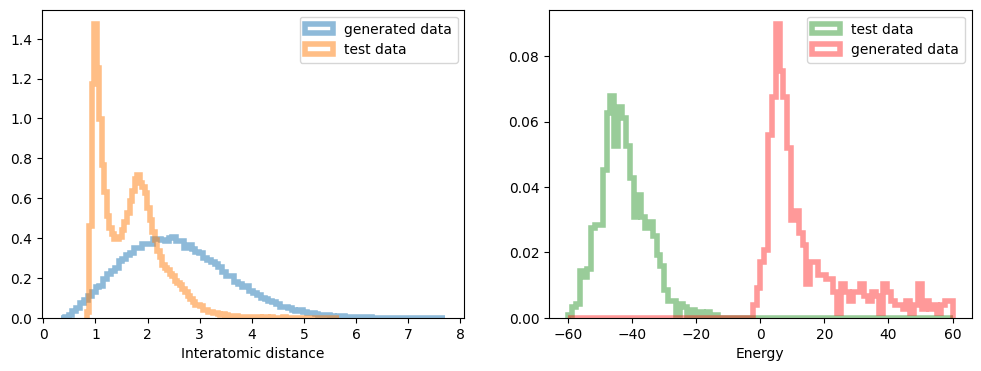

 10%|█         | 1/10 [00:39<05:58, 39.84s/it]

Mean of Energy tensor(-935.4532, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 239.232849
Epoch 49 | Loss 156.153168
Epoch 98 | Loss 117.870483


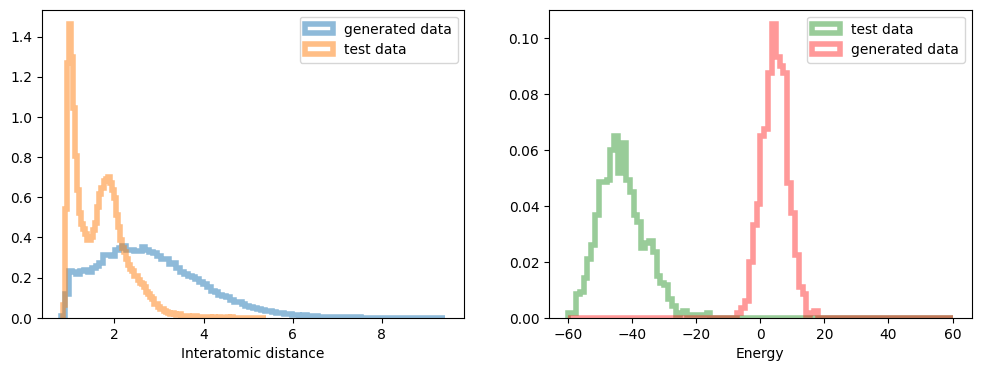

 20%|██        | 2/10 [03:49<17:05, 128.13s/it]

Mean of Energy tensor(-4.6275, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 60.953564
Epoch 49 | Loss 94.952873
Epoch 98 | Loss 57.866661


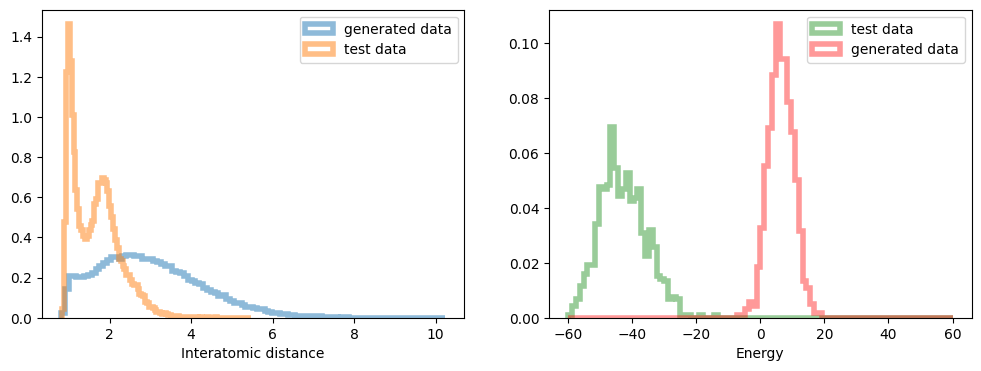

 30%|███       | 3/10 [06:56<18:05, 155.06s/it]

Mean of Energy tensor(-6.5030, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 62.312000


 30%|███       | 3/10 [07:16<16:58, 145.45s/it]


KeyboardInterrupt: 

In [35]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)

            rm_loss= reward_matching_loss(estimate_grad_Rt,
                                          model, 
                                          target,
                                          samples,
                                          t, 
                                          noise_schedule, 
                                          num_mc_samples=num_mc_samples,
                                          clip=True
                                          )
            
            loss = rm_loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
    samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=100,
                                           resampling_interval=None, num_samples=1000, T=1.0)
    samples_energy = target(samples)
    target.get_dataset_fig(samples, T=1.0, T_og=T)
    plt.show()


    # Update Buffer 
    buffer.add(samples, samples_energy)

    print("Mean of Energy", samples_energy.mean())
    
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(batch_size * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

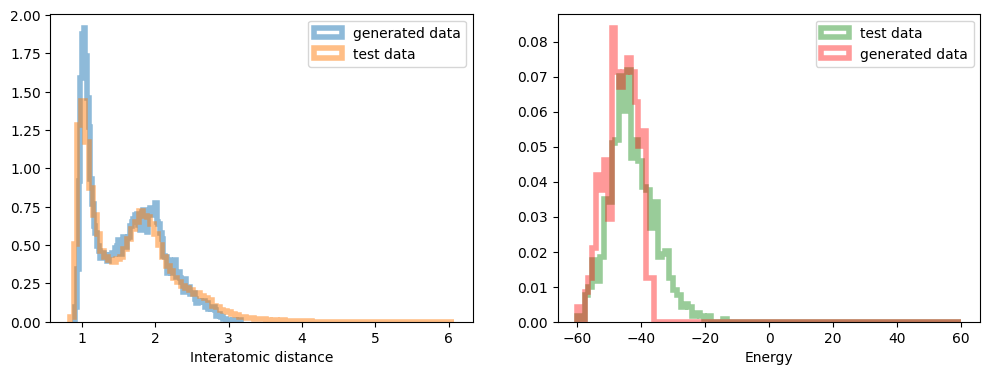

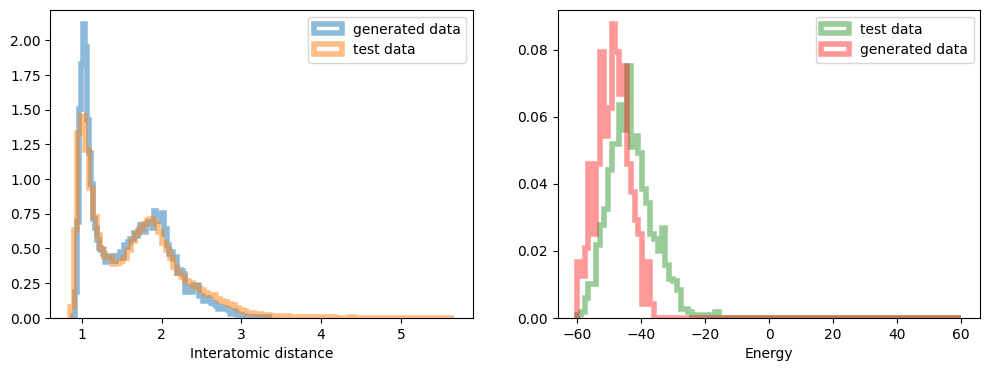

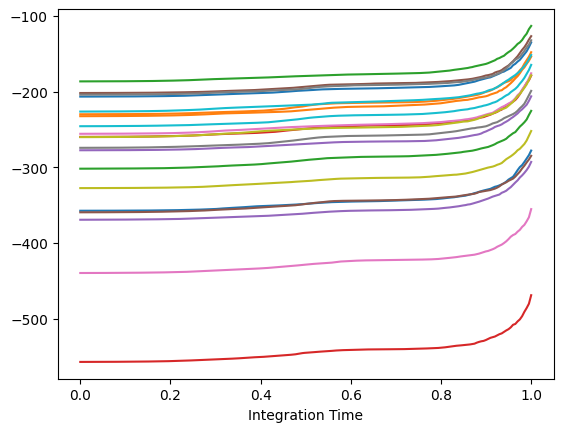

In [41]:
# for plotting

ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
n_steps = 200
samples_weighted = []
samples = []
log_weights = []
for i in range(1):
    prior_samples = prior.sample(200)
    s_weighted, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                                    num_integration_steps=n_steps, resampling_interval=5, T=T)
    s, w = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                            num_integration_steps=n_steps, resampling_interval=n_steps+1, T=T)
    samples_weighted.append(s_weighted)
    samples.append(s)
    log_weights.append(w)

samples_weighted = torch.cat(samples_weighted)
samples = torch.cat(samples)
log_weights = torch.cat(log_weights, dim=1)

target.get_dataset_fig(samples_weighted, T=T, T_og=T)
plt.show()

target.get_dataset_fig(samples, T=T, T_og=T)
plt.show()
plt.plot(torch.linspace(1, 0, n_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.show()


In [19]:
target_lowtemp = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=1.0
    )

samples_energy = target_lowtemp(samples)
samples_weighted_energy = target_lowtemp(samples_weighted)

print("Mean of Energy", samples_energy.mean())
print("Mean of Energy", samples_weighted_energy.mean())
print("True Mean Energy", target_lowtemp(target.test_set).mean())

Mean of Energy tensor(34.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Mean of Energy tensor(30.9028, device='cuda:0', grad_fn=<MeanBackward0>)
True Mean Energy tensor(43.1270, device='cuda:0')
